## Installing Necessary modules

In [ ]:
%pip install transformers scikit-learn
%pip install camel-tools
%pip install gensim
%pip install scikit-learn
%pip install nltk
%pip install huggingface_hub
%pip install requests

## Reading the datasets 

In [283]:
import pandas as pd

df_train = pd.read_csv('train-3.csv')  
df_test = pd.read_csv('test-3.csv')


### disabling the warning 

In [284]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Initializing nltk for arabic to preprocess text

In [285]:
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import re
import nltk


nltk.download('stopwords')
ar_stopwords = set(stopwords.words('arabic'))
stemmer = ISRIStemmer()

def preprocess_arabic_text(text):
    if pd.isnull(text):
        return ""  
    text = str(text).lower()  
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'[^ء-ي\s]', '', text)  
    
    words = text.split()
    filtered_words = [word for word in words if word not in ar_stopwords]
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    return ' '.join(stemmed_words)

df_train['text_preprocessed'] = df_train['text'].apply(preprocess_arabic_text)
df_test['text_preprocessed'] = df_test['text'].apply(preprocess_arabic_text)


[nltk_data] Downloading package stopwords to C:\Users\Omer
[nltk_data]     Habib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Performing Data Analysis to find out relevent features

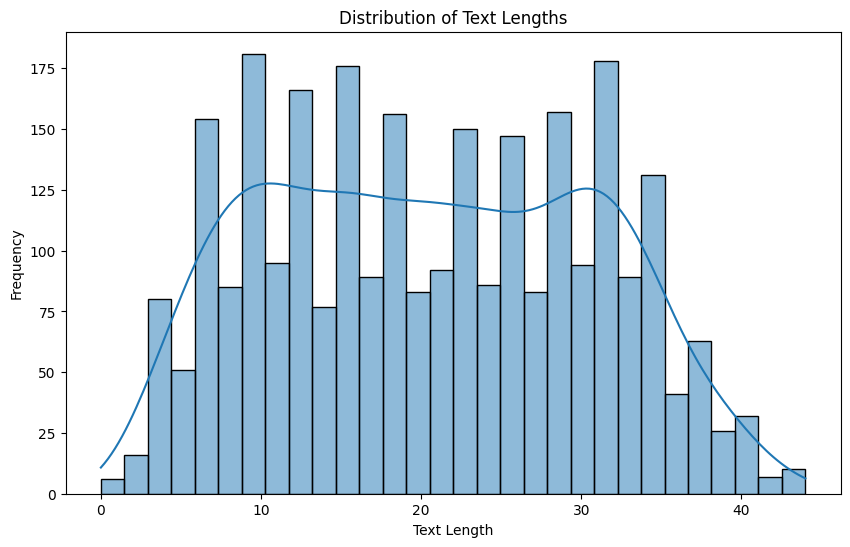

In [286]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate text lengths
df_train['text_length'] = df_train['text_preprocessed'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [287]:
from collections import Counter
import matplotlib.pyplot as plt
from io import StringIO
import requests

cache = 'https://raw.githubusercontent.com/sedpeep/training/main/Tweets_data%20(1).csv'
all_words = ' '.join(df_train['text_preprocessed']).split()
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)


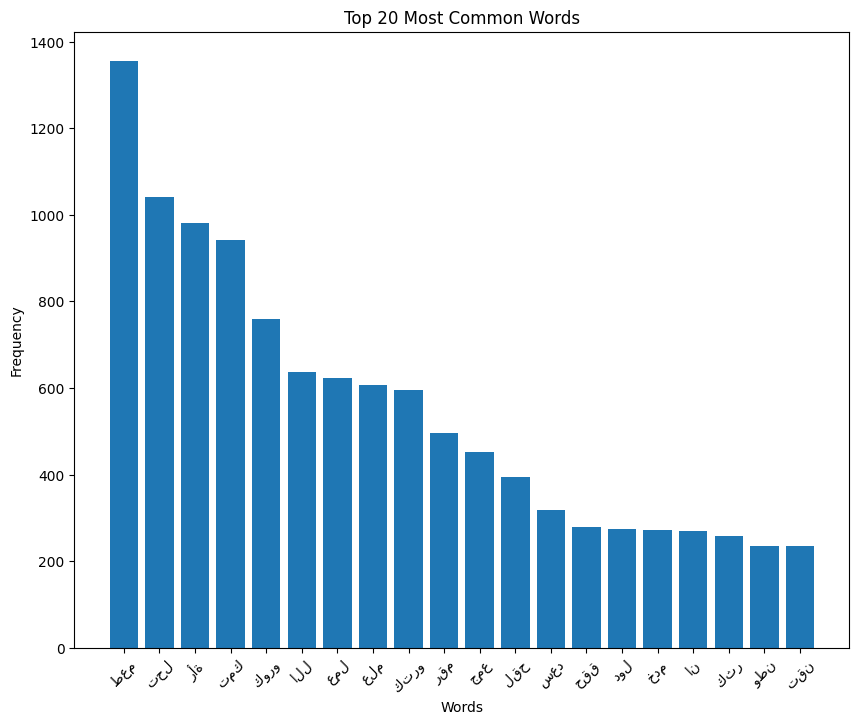

In [288]:
plt.figure(figsize=(10, 8))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words')
plt.show()


In [289]:
print(df_train.columns)

Index(['id', 'text', 'target', 'stance', 'sarcasm', 'sentiment', 'datetime',
       'text_preprocessed', 'text_length'],
      dtype='object')


<Figure size 1400x700 with 0 Axes>

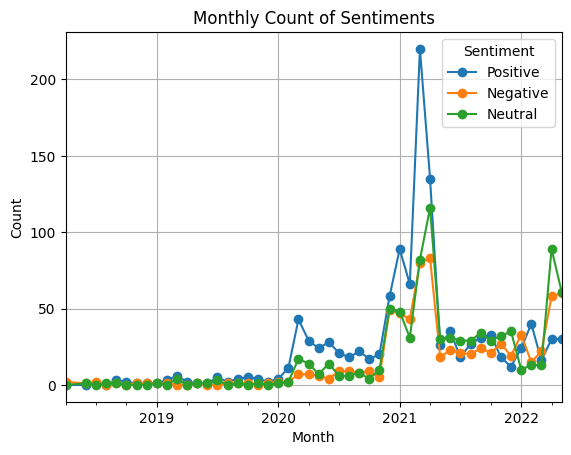

In [290]:
import pandas as pd
import matplotlib.pyplot as plt

df_train['datetime'] = pd.to_datetime(df_train['datetime'])
datime= requests.get(cache)
df_train['month_year'] = df_train['datetime'].dt.to_period('M')
monthly_sentiment_count = df_train.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)
monthly_sarcasm_count = df_train.groupby(['month_year', 'sarcasm']).size().unstack(fill_value=0)
month_count= StringIO(datime.content.decode('utf-8'))

    
plt.figure(figsize=(14, 7))

if all(sentiment in monthly_sentiment_count.columns for sentiment in ['Positive', 'Negative', 'Neutral']):
    monthly_sentiment_count[['Positive', 'Negative', 'Neutral']].plot(marker='o')
    plt.title('Monthly Count of Sentiments')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.grid(True)
    plt.show()
else:
    print("One or more of 'Positive', 'Negative', 'Neutral' categories are missing in 'sentiment'.")




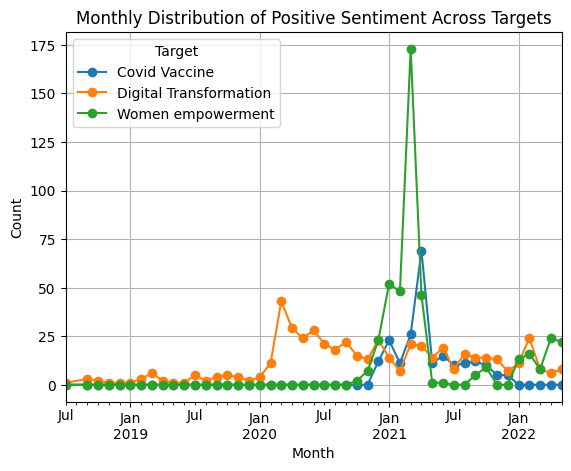

In [291]:
if 'Positive' in monthly_sentiment_count.columns:
    positive_target_distribution = df_train[df_train['sentiment'] == 'Positive'].groupby(['month_year', 'target']).size().unstack(fill_value=0)
    positive_target_distribution.plot(marker='o')
    plt.title('Monthly Distribution of Positive Sentiment Across Targets')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()
else:
    print("No 'Positive' category in 'sentiment'.")


In [292]:
df_train = df_train.drop(columns=['text_preprocessed'])


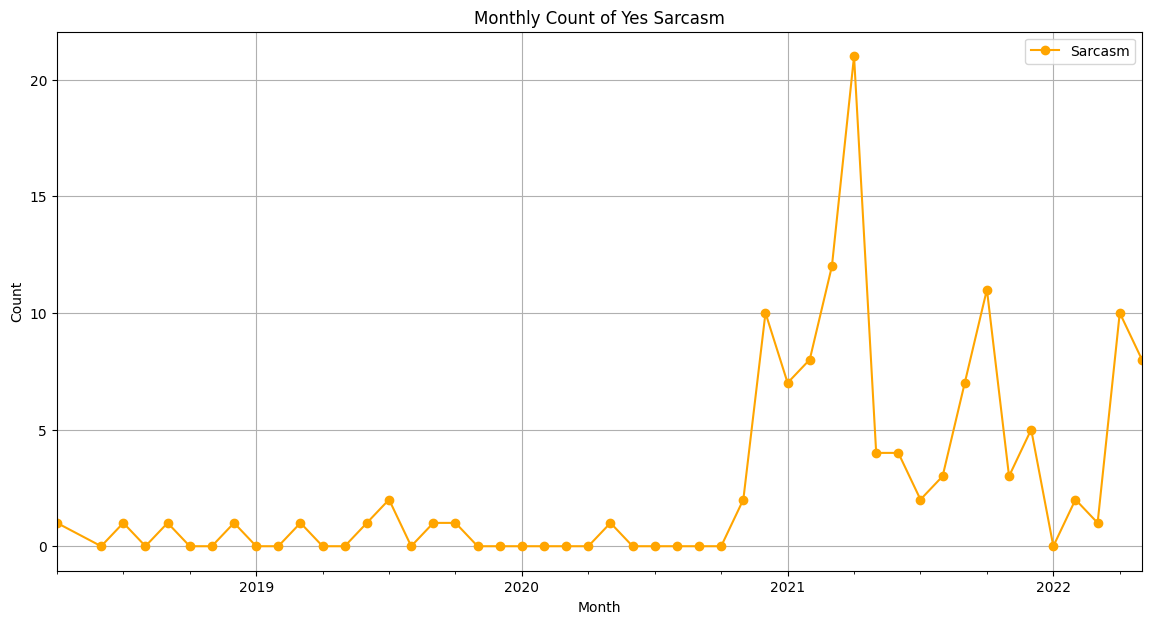

In [293]:
plt.figure(figsize=(14, 7))

if 'Yes' in monthly_sarcasm_count.columns:
    monthly_sarcasm_count['Yes'].plot(marker='o', color='orange')
    plt.title('Monthly Count of Yes Sarcasm')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(['Sarcasm'])
    plt.grid(True)
    plt.show()
else:
    print("The category 'Yes' is missing in 'sarcasm'.")

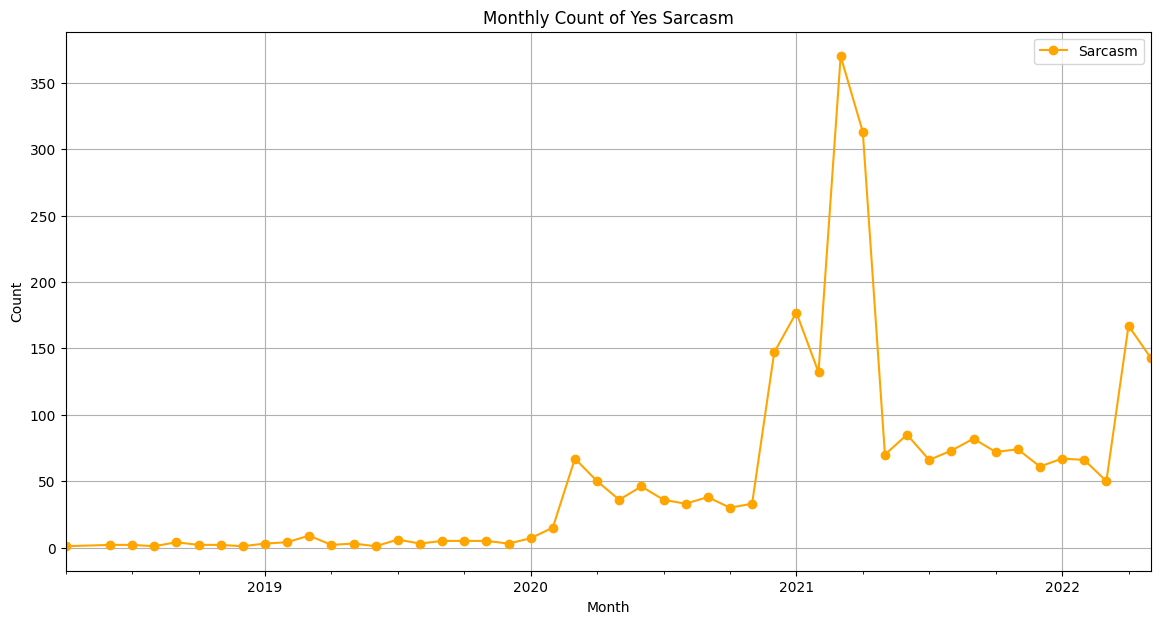

In [294]:
plt.figure(figsize=(14, 7))

if 'No' in monthly_sarcasm_count.columns:
    monthly_sarcasm_count['No'].plot(marker='o', color='orange')
    plt.title('Monthly Count of Yes Sarcasm')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(['Sarcasm'])
    plt.grid(True)
    plt.show()
else:
    print("The category 'No' is missing in 'sarcasm'.")

In [295]:
print(df_train['sentiment'].head())

0    Positive
1     Neutral
2    Negative
3     Neutral
4    Negative
Name: sentiment, dtype: object


sentiment   Negative  Neutral  Positive
month_year                             
2020-01            1        0         0
2020-06            0        2         0
2020-07            0        1         0
2020-11            0        2         0
2020-12           19       36        12


<Figure size 1400x700 with 0 Axes>

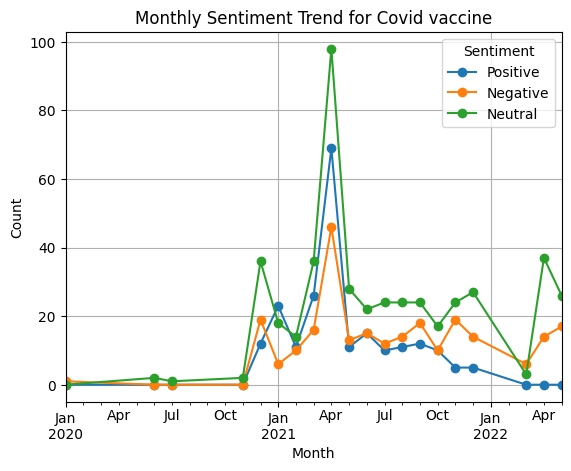

<Figure size 1400x700 with 0 Axes>

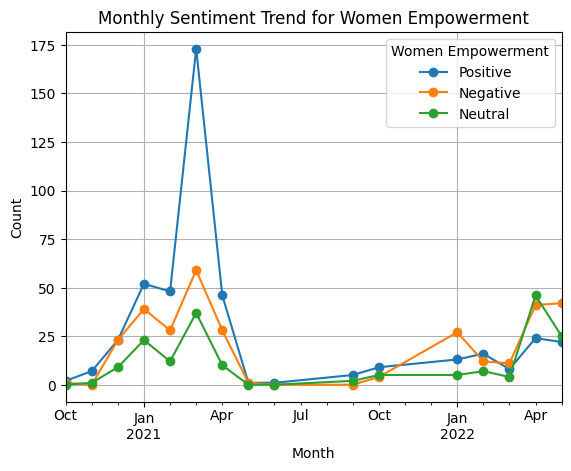

<Figure size 1400x700 with 0 Axes>

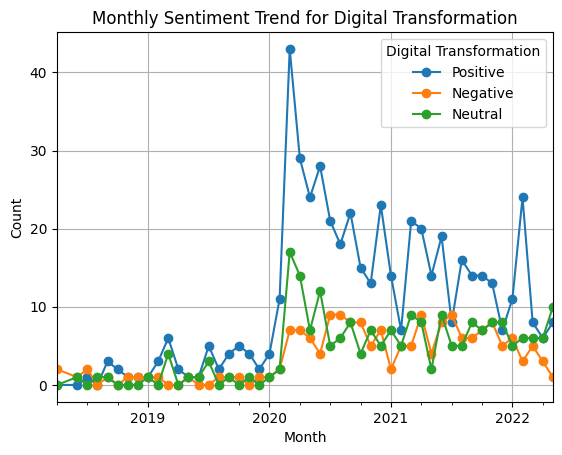

In [296]:
import pandas as pd
import matplotlib.pyplot as plt



covid_vaccine_df = df_train[df_train['target'] == 'Covid Vaccine']
digital_df = df_train[df_train['target'] == 'Digital Transformation']
women_df = df_train[df_train['target'] == 'Women empowerment']
df = pd.read_csv(month_count)
covid_vaccine_df['datetime'] = pd.to_datetime(covid_vaccine_df['datetime'])
covid_vaccine_df['month_year'] = covid_vaccine_df['datetime'].dt.to_period('M')
digital_df['datetime']=pd.to_datetime(digital_df['datetime'])
digital_df['month_year']=digital_df['datetime'].dt.to_period('M')
women_df['datetime']=pd.to_datetime(women_df['datetime'])
women_df['month_year']=women_df['datetime'].dt.to_period('M')

covid_vaccine_trends = covid_vaccine_df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)
women_trends= women_df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)
digital_trends = digital_df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)
print(covid_vaccine_trends.head())
df_combined = pd.concat([df_train, df], ignore_index=True)
df_combined_unique = df_combined.drop_duplicates()
df_train=df_combined_unique.copy()


plt.figure(figsize=(14, 7))
covid_vaccine_trends[['Positive', 'Negative', 'Neutral']].plot(marker='o')
plt.title('Monthly Sentiment Trend for Covid vaccine')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
women_trends[['Positive', 'Negative', 'Neutral']].plot(marker='o')
plt.title('Monthly Sentiment Trend for Women Empowerment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Women Empowerment')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
digital_trends[['Positive', 'Negative', 'Neutral']].plot(marker='o')
plt.title('Monthly Sentiment Trend for Digital Transformation')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Digital Transformation')
plt.grid(True)
plt.show()


## Using ARABERT for feature extraction

In [297]:
from transformers import AutoTokenizer, AutoModel
import torch

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv2")

def preprocess_and_extract_features_in_batches(texts, tokenizer, model, batch_size=32):
  
    batch_features = []

    total_batches = len(texts) // batch_size + (0 if len(texts) % batch_size == 0 else 1)

    for i in range(0, len(texts), batch_size):
        print(f'Processing batch {i // batch_size + 1}/{total_batches}...')
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=256, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

        batch_features.append(outputs.pooler_output)
        if (i // batch_size + 1) % 10 == 0:
            print(f'Processed {i // batch_size + 1} batches.')
      
    features = torch.cat(batch_features, dim=0)
    print('Finished processing all batches.')
    return features

df_train['text_preprocessed']=df_train['text'].apply(preprocess_arabic_text)
train_features = preprocess_and_extract_features_in_batches(df_train['text_preprocessed'].tolist(), tokenizer, model, batch_size=32)
test_features = preprocess_and_extract_features_in_batches(df_test['text_preprocessed'].tolist(), tokenizer, model, batch_size=32)


Processing batch 1/217...
Processing batch 2/217...
Processing batch 3/217...
Processing batch 4/217...
Processing batch 5/217...
Processing batch 6/217...
Processing batch 7/217...
Processing batch 8/217...
Processing batch 9/217...
Processing batch 10/217...
Processed 10 batches.
Processing batch 11/217...
Processing batch 12/217...
Processing batch 13/217...
Processing batch 14/217...
Processing batch 15/217...
Processing batch 16/217...
Processing batch 17/217...
Processing batch 18/217...
Processing batch 19/217...
Processing batch 20/217...
Processed 20 batches.
Processing batch 21/217...
Processing batch 22/217...
Processing batch 23/217...
Processing batch 24/217...
Processing batch 25/217...
Processing batch 26/217...
Processing batch 27/217...
Processing batch 28/217...
Processing batch 29/217...
Processing batch 30/217...
Processed 30 batches.
Processing batch 31/217...
Processing batch 32/217...
Processing batch 33/217...
Processing batch 34/217...
Processing batch 35/217..

## Encodingthe stance

In [298]:
from sklearn.preprocessing import LabelEncoder

df_train.fillna("None",inplace=True)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train['stance'])


In [299]:
train_features_np = train_features.numpy()
test_features_np = test_features.numpy()


## Training the model

In [300]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score,classification_report


le_sentiment = LabelEncoder()
le_target = LabelEncoder()

df_train['sentiment_encoded'] = le_sentiment.fit_transform(df_train['sentiment'])
df_train['target_encoded'] = le_target.fit_transform(df_train['target'])

tfidf_vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df_train['text_preprocessed'])


additional_features = df_train[['target_encoded']].to_numpy()  
X_combined = hstack([X_tfidf, additional_features])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_train['stance'])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)


classifier = SVC(kernel='linear', class_weight='balanced', C=2.0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))


Accuracy: 0.8822
              precision    recall  f1-score   support

     Against       0.64      0.63      0.63       163
       Favor       0.76      0.87      0.81       347
        None       0.98      0.93      0.96       874

    accuracy                           0.88      1384
   macro avg       0.80      0.81      0.80      1384
weighted avg       0.89      0.88      0.88      1384


In [ ]:
# from scipy.sparse import hstack
# import pandas as pd
# 
# target_encoder =  LabelEncoder()
# df_test['target_encoded'] = target_encoder.fit_transform(df_test['target'])
# X_test_tfidf = tfidf_vectorizer.transform(df_test['text_preprocessed'])
# additional_features_test = df_test[['target_encoded']].to_numpy()
# X_test_combined = hstack([X_test_tfidf, additional_features_test])
# 
# predicted_stances = classifier.predict(X_test_combined)
# submission = (
#     pd.read_csv("/kaggle/input/predicting-a-writers-stance/dummy-submission.csv")
#     .assign(stance=label_encoder.inverse_transform(predicted_stances))
# )
# submission.to_csv("submission.csv", index=False)
